# Win probability vs models

The purpose of this notebook is to compare the predicted win probability for models with measures of how much a team won by. This will be used in the paper.

In [147]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Predictions data

In [148]:
df = pd.read_csv('../data/Final Data/start_to_finish_with_preds_and_scores.csv')

In [149]:
df.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,xgb_pred,knn_pred,knn_no_batting_pred,nn_pred,xgb_proba,knn_proba,knn_no_batting_proba,nn_proba,home_score,away_score
0,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,0.0,0.0,1.0,0,0.452681,0.500000,0.520000,0.455505,4,1
1,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,0.0,0.0,1.0,0,0.452681,0.500000,0.520000,0.455505,6,5
2,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,0.0,0.0,1.0,0,0.452681,0.500000,0.520000,0.455505,5,1
3,-0.100639,-0.023374,-0.075552,4.0,1.214434,-0.018717,-0.010464,2.0,0.0,-0.010464,...,0.0,0.0,1.0,0,0.377228,0.473333,0.506667,0.395637,3,5
4,0.028053,0.009820,0.030927,1.0,1.179045,0.077540,-0.010464,83.0,0.0,-0.010464,...,1.0,1.0,1.0,1,0.629717,0.533333,0.546667,0.508145,4,3


In [150]:
df['Y'].min(), df['Y'].max()

(2016, 2019)

## Score differential

We will model score differential by a probability distribution. The idea is to transform the score differential into a scale that makes sense. For example, is winning by 2 "twice as good" as winning by 1? Probably not. So we want to probabilistically rescale it so that score differentials are expressed in a historical context.

We'll do this by getting an answer to the following question: In what percentage of all games did the home team win by the given score differential or less? For example, in what percentage of games did the home team win by 5 or less runs?

While this is phrased in terms of home team wins, obviously the away team can win as well. So a negative score differential will indicate an away team win. Thus "what percentage of the time did the home team win by -3 or less" is equivalent to saying "what percentage of the time did the away team win by 3 or less."

The advantage of this approach is two-fold:
1. It scales the score differential between -1 and 1
2. It allows context, as discussed above.

### Raw score differential

In [151]:
df['score_diff'] = df['home_score'] - df['away_score']

<AxesSubplot:ylabel='Frequency'>

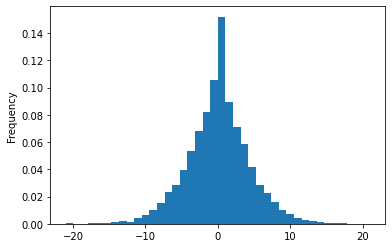

In [152]:
df['score_diff'].plot(kind='hist', density=True, bins=40)

### Scaled score differential

Split into home and away team wins.

In [153]:
home_win_df = df[df['home_win'] == 1]
away_win_df = df[df['home_win'] == 0]

In [154]:
assert home_win_df.shape[0] + away_win_df.shape[0] == df.shape[0]

<AxesSubplot:ylabel='Frequency'>

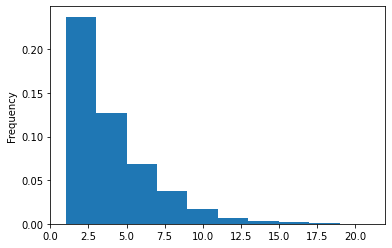

In [155]:
home_win_df['score_diff'].plot(kind='hist', density=True)

<AxesSubplot:ylabel='Frequency'>

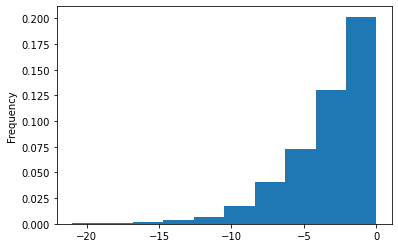

In [156]:
away_win_df['score_diff'].plot(kind='hist', density=True)

Create cumulative distributions by summing up from zero to $\pm$ largest score differential.

In [157]:
home_prob_by_diff = home_win_df['score_diff'].value_counts().sort_index() / home_win_df.shape[0]
away_prob_by_diff = away_win_df['score_diff'].value_counts().sort_index() / away_win_df.shape[0]
home_prob_by_diff

1     0.298597
2     0.175988
3     0.139734
4     0.114593
5     0.081253
6     0.055383
7     0.043906
8     0.031882
9     0.019311
10    0.014028
11    0.008563
12    0.005283
13    0.004372
14    0.002551
15    0.001457
16    0.001640
17    0.000547
18    0.000364
19    0.000182
20    0.000182
21    0.000182
Name: score_diff, dtype: float64

In [158]:
away_prob_by_diff

-21    0.000209
-20    0.000418
-19    0.000209
-18    0.000209
-17    0.000836
-16    0.000836
-15    0.001880
-14    0.002716
-13    0.004805
-12    0.003760
-11    0.010236
-10    0.015041
-9     0.022352
-8     0.033633
-7     0.052851
-6     0.064759
-5     0.088991
-4     0.119699
-3     0.153123
-2     0.185502
-1     0.237727
 0     0.000209
Name: score_diff, dtype: float64

In [159]:
home_win_cdf = np.cumsum(home_prob_by_diff)

# Since score differentials in away_prob_by_diff are negative, we need to sum it up backwards. 
# https://stackoverflow.com/questions/16541618/perform-a-reverse-cumulative-sum-on-a-numpy-array/16541726
# We also make it negative so that away team wins have negative dominance.
away_win_cdf = -np.cumsum(away_prob_by_diff[::-1])[::-1]

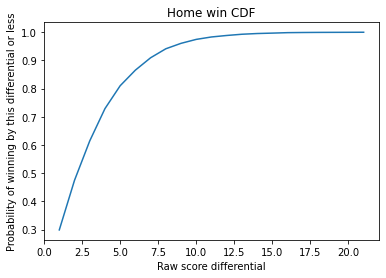

In [160]:
plt.plot(home_win_cdf.index, home_win_cdf)
plt.xlabel('Raw score differential')
plt.ylabel('Probability of winning by this differential or less')
plt.title('Home win CDF');

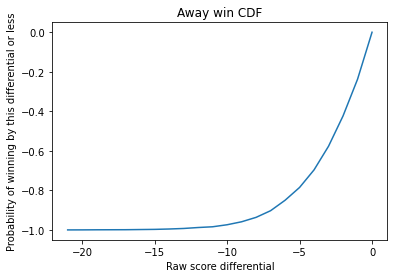

In [161]:
plt.plot(away_win_cdf.index, away_win_cdf)
plt.xlabel('Raw score differential')
plt.ylabel('Probability of winning by this differential or less')
plt.title('Away win CDF');

In [162]:
dominance_df = pd.concat([away_win_cdf, home_win_cdf])

In [163]:
dominance_df

-21   -1.000000
-20   -0.999791
-19   -0.999373
-18   -0.999164
-17   -0.998956
-16   -0.998120
-15   -0.997284
-14   -0.995404
-13   -0.992689
-12   -0.987884
-11   -0.984124
-10   -0.973888
-9    -0.958847
-8    -0.936495
-7    -0.902862
-6    -0.850010
-5    -0.785252
-4    -0.696261
-3    -0.576562
-2    -0.423438
-1    -0.237936
 0    -0.000209
 1     0.298597
 2     0.474586
 3     0.614320
 4     0.728912
 5     0.810166
 6     0.865549
 7     0.909455
 8     0.941337
 9     0.960649
 10    0.974677
 11    0.983239
 12    0.988522
 13    0.992895
 14    0.995445
 15    0.996903
 16    0.998543
 17    0.999089
 18    0.999453
 19    0.999636
 20    0.999818
 21    1.000000
Name: score_diff, dtype: float64

Looks like a sigmoid function!

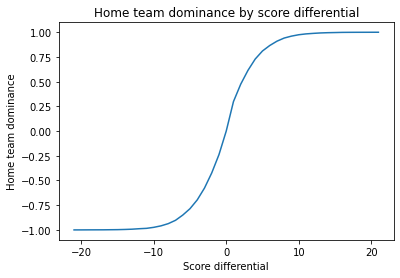

In [164]:
plt.plot(dominance_df.index, dominance_df.values)
plt.title('Home team dominance by score differential')
plt.xlabel('Score differential')
plt.ylabel('Home team dominance');

Now let's make a function which, given a score differential, returns the "dominance" score.

In [165]:
def dominance(score_diff):
    return dominance_df.loc[score_diff]

## Dominance vs predicted probability

In [166]:
df['dominance'] = df['score_diff'].map(dominance)

In [167]:
df['nn_proba_scaled'] = (df['nn_proba'] - 0.5) * 2
df['xgb_proba_scaled'] = (df['xgb_proba'] - 0.5) * 2
df['knn_proba_scaled'] = (df['knn_proba'] - 0.5) * 2

In [168]:
df['nn_proba_scaled_rounded'] = np.round(df['nn_proba_scaled'], 1)
df['xgb_proba_scaled_rounded'] = np.round(df['xgb_proba_scaled'], 1)
df['knn_proba_scaled_rounded'] = np.round(df['knn_proba_scaled'], 1)

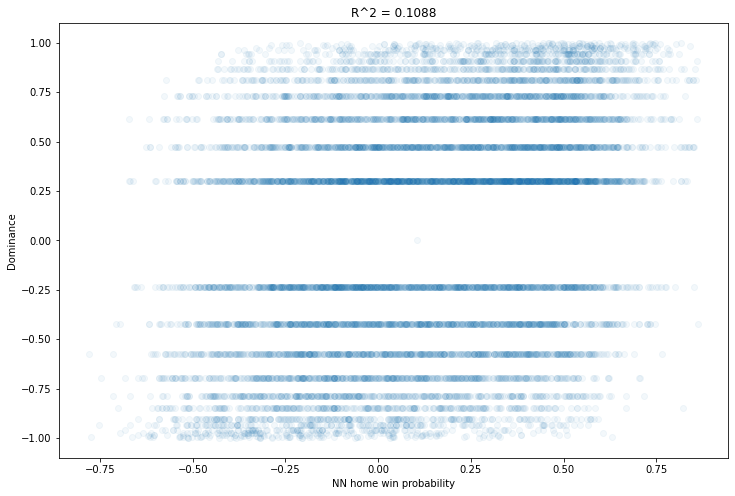

In [169]:
plt.figure(figsize=(12, 8))
plt.scatter((df['nn_proba'] - 0.5) * 2, df['dominance'], alpha=0.05)
plt.xlabel('NN home win probability')
plt.ylabel('Dominance');
plt.title(f'R^2 = {np.corrcoef(df["dominance"], df["nn_proba"])[0, 1]**2:.4f}');

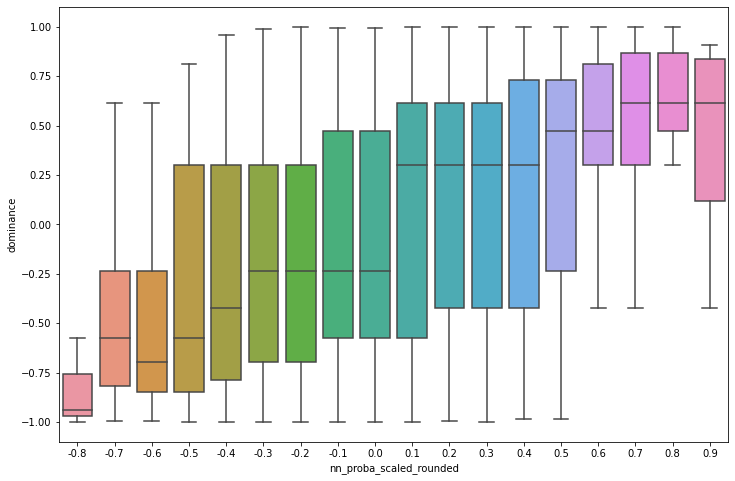

In [170]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='nn_proba_scaled_rounded', y='dominance', data=df, fliersize=0, orient='v');

<AxesSubplot:xlabel='nn_proba_scaled', ylabel='dominance'>

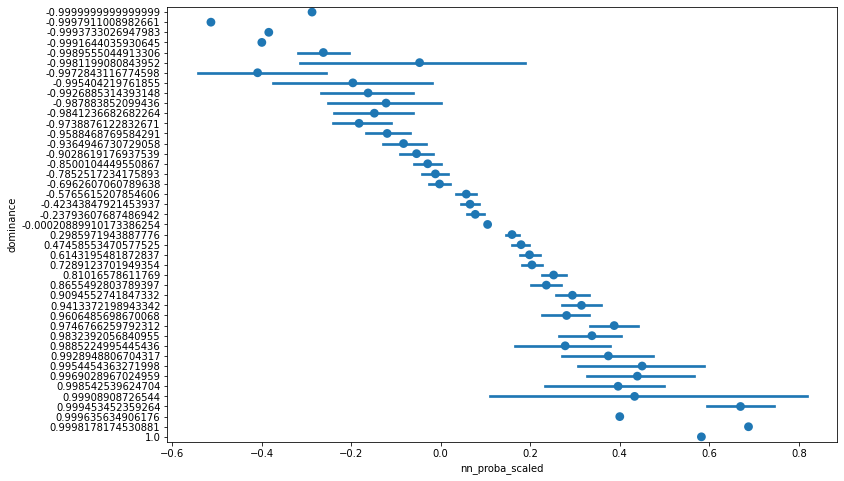

In [171]:
plt.figure(figsize=(12, 8))

sns.pointplot(x='nn_proba_scaled', y='dominance', data=df, orient='h', join=False)

<AxesSubplot:xlabel='nn_proba_scaled_rounded', ylabel='dominance'>

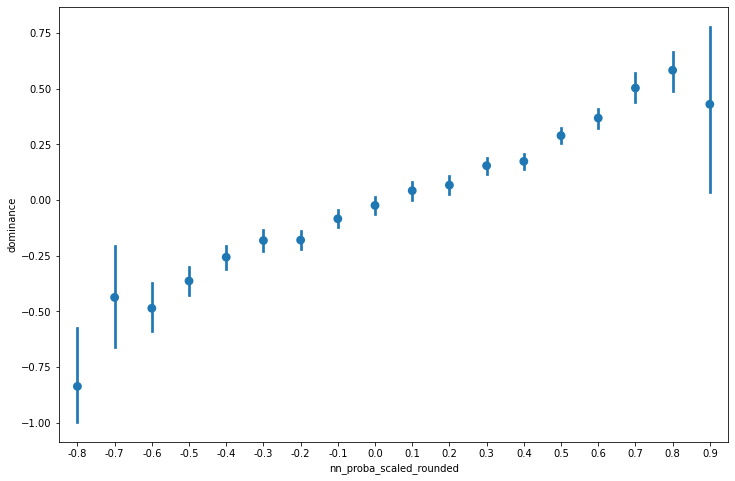

In [172]:
plt.figure(figsize=(12, 8))

sns.pointplot(x='nn_proba_scaled_rounded', y='dominance', data=df, orient='v', join=False)

<AxesSubplot:xlabel='nn_proba_scaled_rounded', ylabel='score_diff'>

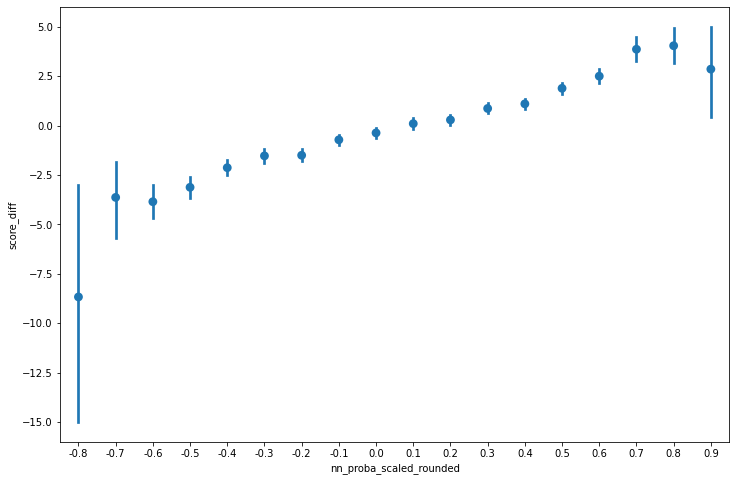

In [173]:
plt.figure(figsize=(12, 8))

sns.pointplot(x='nn_proba_scaled_rounded', y='score_diff', data=df, orient='v', join=False)

<AxesSubplot:xlabel='nn_proba_scaled', ylabel='score_diff'>

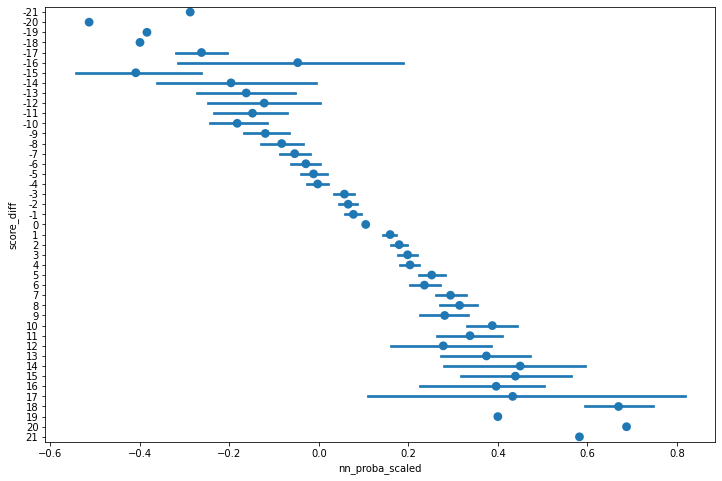

In [174]:
plt.figure(figsize=(12, 8))

sns.pointplot(x='nn_proba_scaled', y='score_diff', data=df, orient='h', join=False)

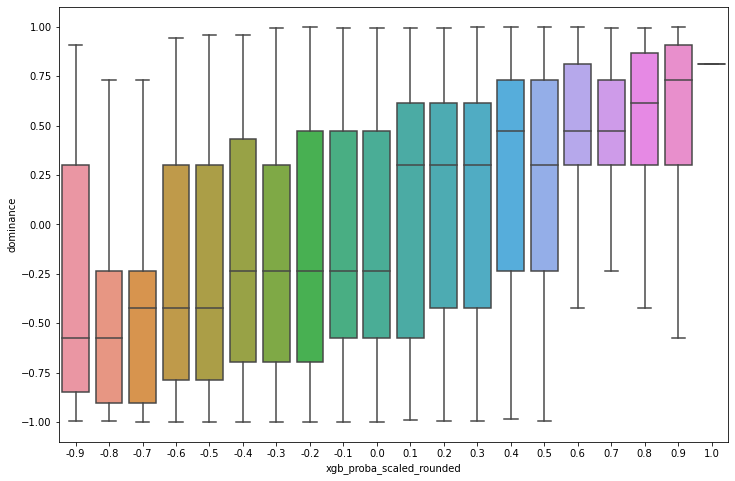

In [175]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='xgb_proba_scaled_rounded', y='dominance', data=df, fliersize=0, orient='v');

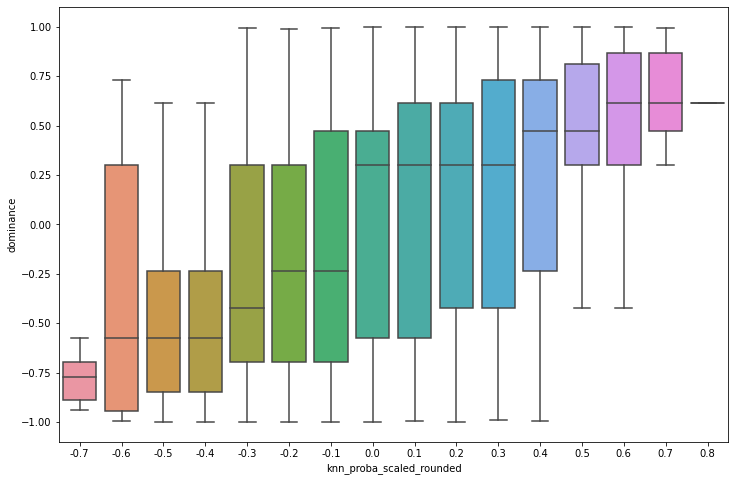

In [176]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='knn_proba_scaled_rounded', y='dominance', data=df, fliersize=0, orient='v');

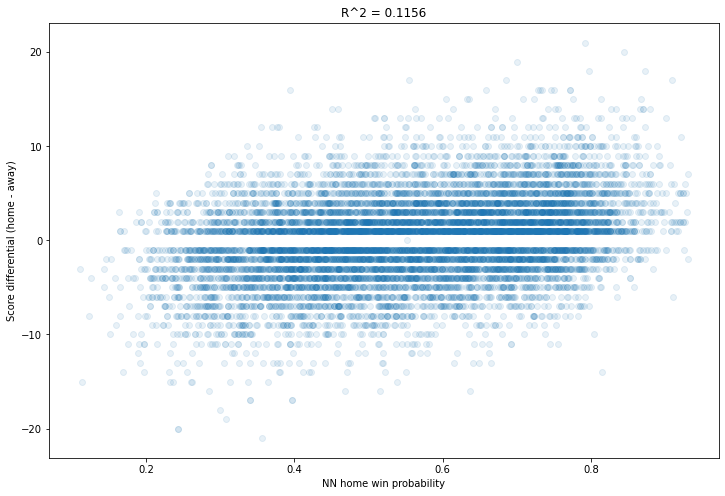

In [177]:
plt.figure(figsize=(12, 8))
plt.scatter(df['nn_proba'], df['score_diff'], alpha=0.1)
plt.xlabel('NN home win probability')
plt.ylabel('Score differential (home - away)');
plt.title(f'R^2 = {np.corrcoef(df["nn_proba"], df["score_diff"])[0, 1]**2:.4f}');

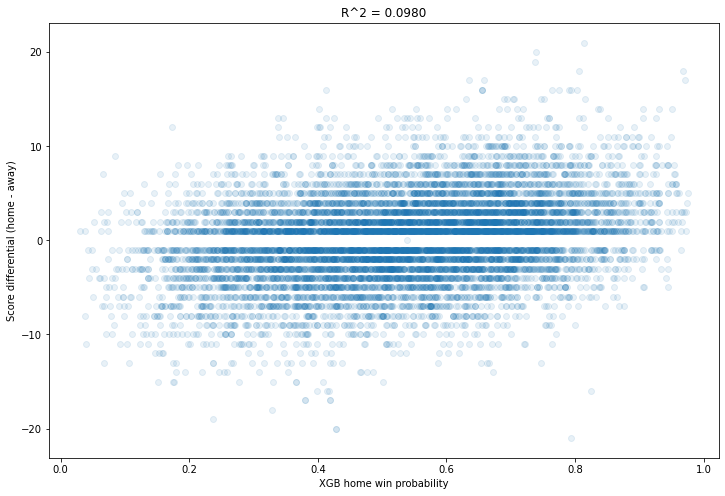

In [178]:
plt.figure(figsize=(12, 8))
plt.scatter(df['xgb_proba'], df['score_diff'], alpha=0.1)
plt.xlabel('XGB home win probability')
plt.ylabel('Score differential (home - away)');
plt.title(f'R^2 = {np.corrcoef(df["xgb_proba"], df["score_diff"])[0, 1]**2:.4f}');

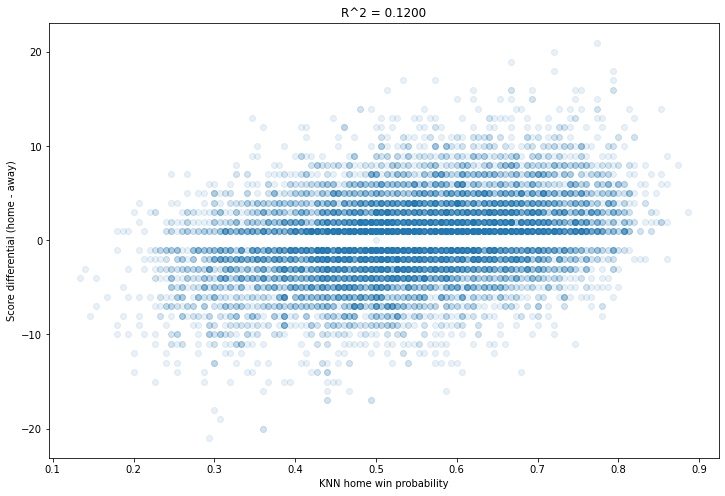

In [179]:
plt.figure(figsize=(12, 8))
plt.scatter(df['knn_proba'], df['score_diff'], alpha=0.1)
plt.xlabel('KNN home win probability')
plt.ylabel('Score differential (home - away)');
plt.title(f'R^2 = {np.corrcoef(df["knn_proba"], df["score_diff"])[0, 1]**2:.4f}');

## Statistics

Here I'll calculate some relevant statistics. These will be good for including in the abstract. In general, the statistics below focus more on the _probabilities_, rather than on simply making a correct prediction or not. We know our models don't make win/loss predictions at _quite_ state of the art, they're slightly below. But our probabilities are better, as the metrics below show.

### Brier score

[Discussed here](https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/), lower is better. The Brier scores below are in-line with or better than in the papers we read.

In [180]:
from sklearn.metrics import brier_score_loss

In [181]:
print(f'NN Brier score = {brier_score_loss(df["home_win"], df["nn_proba"]):.4f}')
print(f'XGB Brier score = {brier_score_loss(df["home_win"], df["xgb_proba"]):.4f}')
print(f'KNN Brier score = {brier_score_loss(df["home_win"], df["knn_proba"]):.4f}')

NN Brier score = 0.2292
XGB Brier score = 0.2340
KNN Brier score = 0.2274


### Area under ROC curve
[Discussed here](https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/), higher is better. These are better than in the papers we read.

In [182]:
from sklearn.metrics import roc_auc_score

In [183]:
print(f"NN AUROC = {roc_auc_score(df['home_win'], df['nn_proba']):.4f}")
print(f"XGB AUROC = {roc_auc_score(df['home_win'], df['xgb_proba']):.4f}")
print(f"KNN AUROC = {roc_auc_score(df['home_win'], df['knn_proba']):.4f}")

NN AUROC = 0.6653
XGB AUROC = 0.6518
KNN AUROC = 0.6686


## Comparison to 538

Fivethirtyeight makes their [predictions available](https://github.com/fivethirtyeight/data/tree/master/mlb-elo), which include win probabilities. Let's compare our results to theirs.

In [184]:
fte_df = pd.read_csv('../data/538_mlb_elo.csv')

Per [the documentation](https://github.com/fivethirtyeight/data/tree/master/mlb-elo), `team1` is always the home team, and `elo_prob1` is the predicted probability of the home team winning.

In [185]:
fte_df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2021-10-03,2021,0,NaN,ATL,NYM,1551.109895,1503.501067,0.601619,0.398381,...,NaN,NaN,NaN,NaN,0.575795,0.424205,NaN,NaN,NaN,NaN
1,2021-10-03,2021,0,NaN,STL,CHC,1502.349243,1468.771068,0.582111,0.417889,...,NaN,NaN,NaN,NaN,0.566486,0.433514,NaN,NaN,NaN,NaN
2,2021-10-03,2021,0,NaN,SEA,ANA,1506.798810,1481.622155,0.570302,0.429698,...,NaN,NaN,NaN,NaN,0.545822,0.454178,NaN,NaN,NaN,NaN
3,2021-10-03,2021,0,NaN,LAD,MIL,1595.777724,1547.693001,0.602275,0.397725,...,NaN,NaN,NaN,NaN,0.614708,0.385292,NaN,NaN,NaN,NaN
4,2021-10-03,2021,0,NaN,KCR,MIN,1469.856717,1482.131210,0.516868,0.483132,...,NaN,NaN,NaN,NaN,0.498403,0.501597,NaN,NaN,NaN,NaN


In [186]:
fte_df = fte_df[fte_df['season'] >= 2016]
fte_df = fte_df[fte_df['season'] <= 2019]

Based on eyeballing the data and [the website](https://projects.fivethirtyeight.com/2019-mlb-predictions/games/) _I think_ `team1` is the away team and `team2` is the home team.

In [187]:
fte_df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
3380,2019-10-30,2019,0,w,HOU,WSN,1599.542804,1584.363378,0.574617,0.425383,...,56.920649,61.723620,0.989236,27.776342,0.515172,0.484828,1587.973463,1583.382133,2.0,6.0
3381,2019-10-29,2019,0,w,HOU,WSN,1605.069000,1578.837182,0.595209,0.404791,...,62.975093,60.272516,28.723451,21.776276,0.594638,0.405362,1591.026009,1580.329587,2.0,7.0
3382,2019-10-27,2019,0,w,WSN,HOU,1584.005206,1599.900976,0.515546,0.484454,...,49.433198,66.891460,-29.811205,47.888341,0.373102,0.626898,1576.189971,1595.165625,1.0,7.0
3383,2019-10-26,2019,0,w,WSN,HOU,1589.985555,1593.920627,0.538425,0.461575,...,56.003581,51.251046,0.823752,-24.893480,0.586974,0.413026,1578.722119,1592.633477,1.0,8.0
3384,2019-10-25,2019,0,w,WSN,HOU,1593.827376,1590.078806,0.553044,0.446956,...,54.036365,57.096801,-9.053908,2.440389,0.526852,0.473148,1583.715416,1587.640180,1.0,4.0


In [188]:
fte_df['score_diff'] = fte_df['score1'] - fte_df['score2']

In [189]:
fte_df['home_win_prob_rounded'] = fte_df['elo_prob1'].apply(lambda x: np.round(x, 1))
fte_df['home_win_prob_rounded_scaled'] = (2 * (fte_df['elo_prob1'] - 0.5)).apply(lambda x: np.round(x, 1))

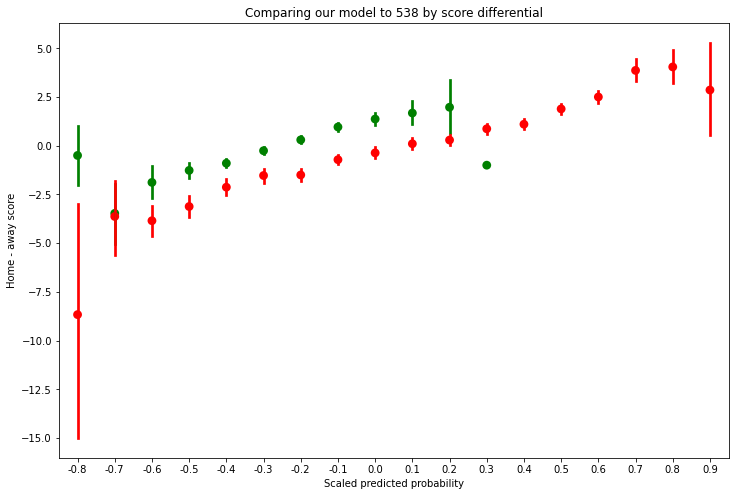

In [190]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.pointplot(x='home_win_prob_rounded_scaled', y='score_diff', data=fte_df, orient='v', join=False, label='538', color='green')
sns.pointplot(x='nn_proba_scaled_rounded', y='score_diff', data=df, orient='v', join=False, label='NN', color='red')
plt.xlabel('Scaled predicted probability')
plt.ylabel('Home - away score')
plt.title('Comparing our model to 538 by score differential');

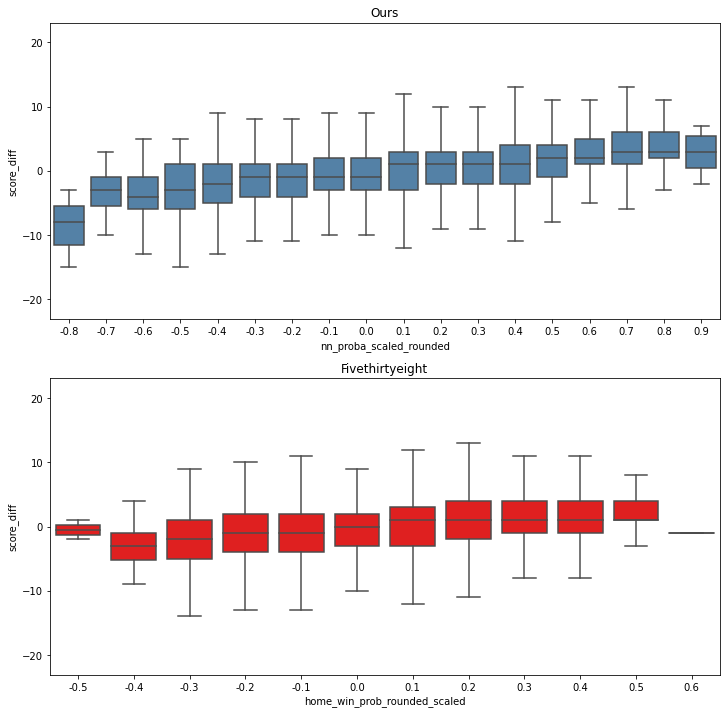

In [526]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

sns.boxplot(x='nn_proba_scaled_rounded', y='score_diff', data=df, ax=axs[0],  fliersize=0, orient='v', color='steelblue');
axs[0].set_title('Ours')
sns.boxplot(x='home_win_prob_rounded_scaled', y='score_diff', data=fte_df, ax=axs[1], fliersize=0, orient='v', color='red')
axs[1].set_title('Fivethirtyeight');

Also comparing dominance.

In [192]:
fte_df['dominance'] = fte_df['score_diff'].apply(dominance)

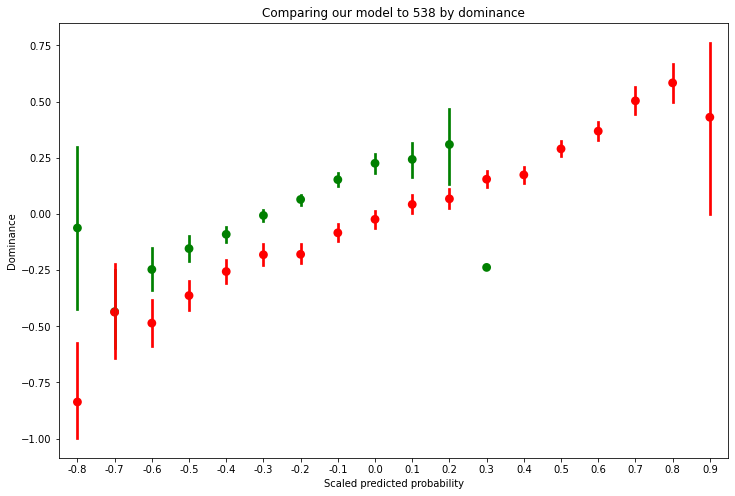

In [193]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.pointplot(x='home_win_prob_rounded_scaled', y='dominance', data=fte_df, orient='v', join=False, label='538', color='green')
sns.pointplot(x='nn_proba_scaled_rounded', y='dominance', data=df, orient='v', join=False, label='NN', color='red')
plt.xlabel('Scaled predicted probability')
plt.ylabel('Dominance')
plt.title('Comparing our model to 538 by dominance');

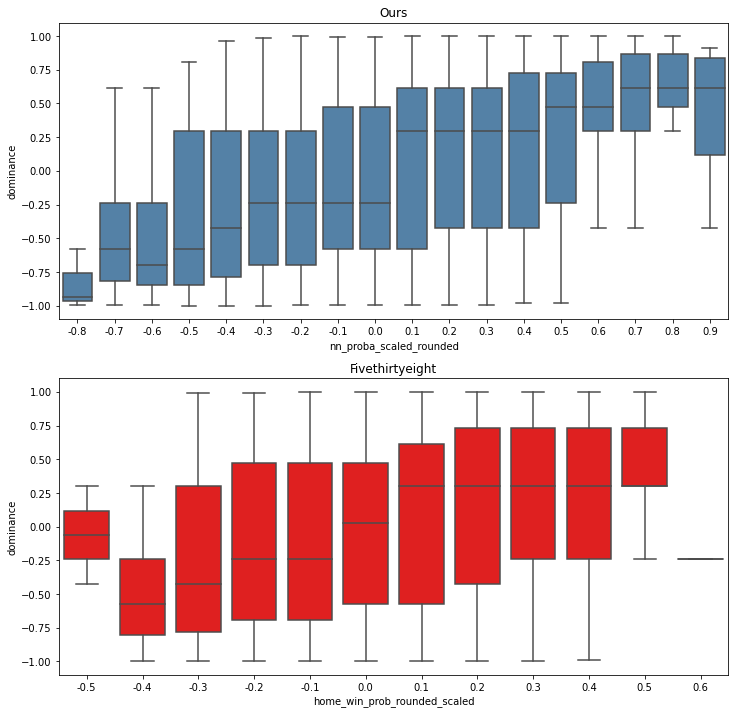

In [527]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

sns.boxplot(x='nn_proba_scaled_rounded', y='dominance', data=df, ax=axs[0],  fliersize=0, orient='v', color='steelblue');
axs[0].set_title('Ours')
sns.boxplot(x='home_win_prob_rounded_scaled', y='dominance', data=fte_df, ax=axs[1], fliersize=0, orient='v', color='red')
axs[1].set_title('Fivethirtyeight');

Repeat again, now using `rating_prob1`

In [194]:
fte_df['home_win_rating_prob_rounded'] = fte_df['rating_prob1'].apply(lambda x: np.round(x, 1))
fte_df['home_win_rating_prob_rounded_scaled'] = (2 * (fte_df['rating_prob1'] - 0.5)).apply(lambda x: np.round(x, 1))

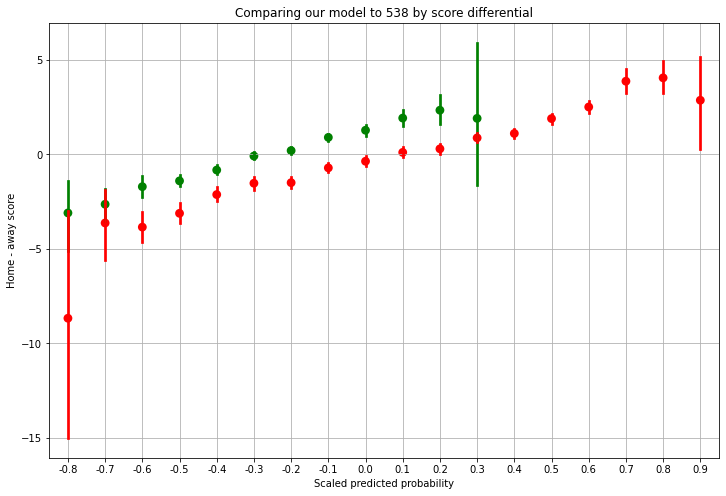

In [195]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.pointplot(x='home_win_rating_prob_rounded_scaled', y='score_diff', data=fte_df, orient='v', join=False, label='538', color='green')
sns.pointplot(x='nn_proba_scaled_rounded', y='score_diff', data=df, orient='v', join=False, label='NN', color='red')
plt.xlabel('Scaled predicted probability')
plt.ylabel('Home - away score')
plt.grid()
plt.title('Comparing our model to 538 by score differential');

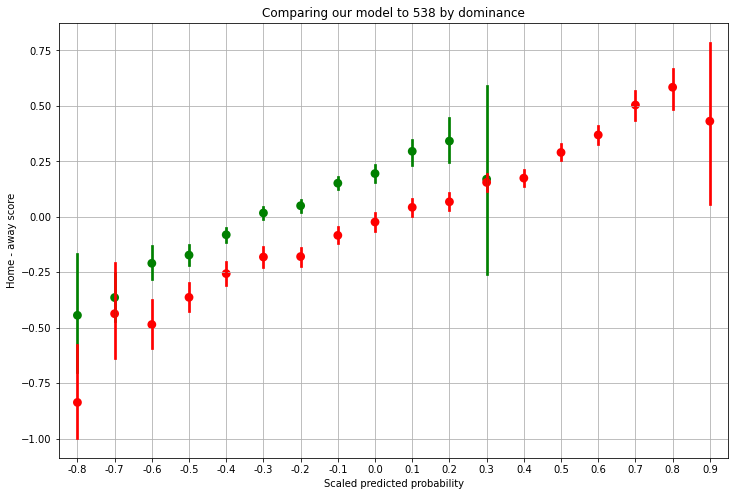

In [196]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.pointplot(x='home_win_rating_prob_rounded_scaled', y='dominance', data=fte_df, orient='v', join=False, label='538', color='green')
sns.pointplot(x='nn_proba_scaled_rounded', y='dominance', data=df, orient='v', join=False, label='NN', color='red')
plt.xlabel('Scaled predicted probability')
plt.ylabel('Home - away score')
plt.grid()
plt.title('Comparing our model to 538 by dominance');

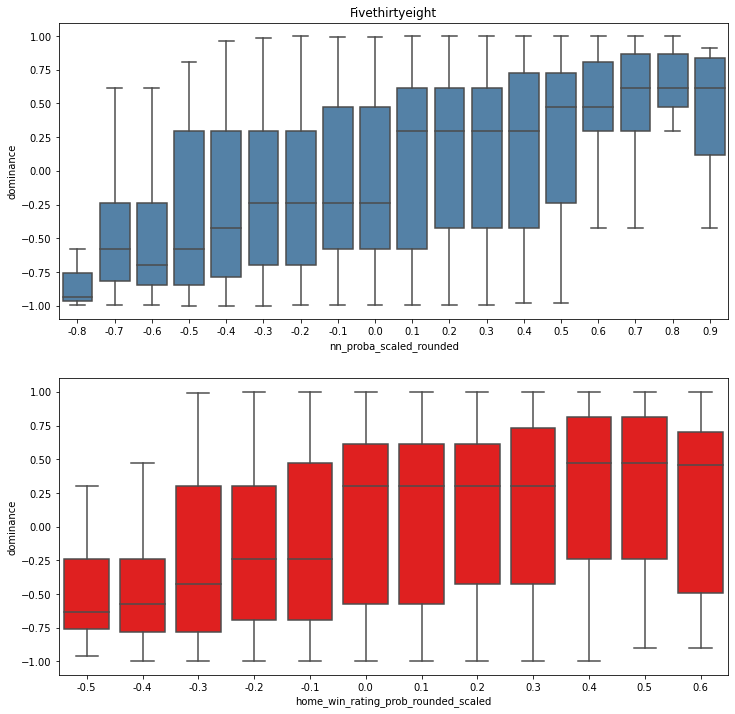

In [258]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

sns.boxplot(x='nn_proba_scaled_rounded', y='dominance', data=df, ax=axs[0],  fliersize=0, orient='v', color='steelblue');
axs[0].set_title('Ours')
sns.boxplot(x='home_win_rating_prob_rounded_scaled', y='dominance', data=fte_df, ax=axs[1], fliersize=0, orient='v', color='red')
axs[0].set_title('Fivethirtyeight');

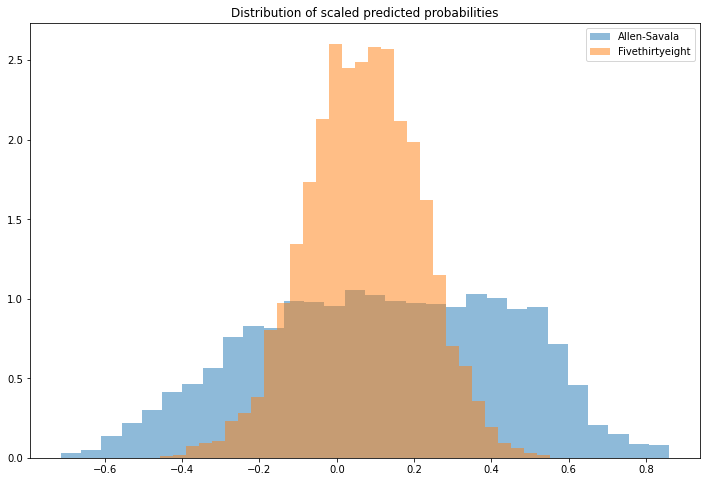

In [263]:
plt.figure(figsize=(12, 8))

plt.hist(df['nn_proba_scaled'], bins=30, label='Allen-Savala', density=True, alpha=0.5)
plt.hist(2 * (fte_df['elo_prob1'] - 0.5), bins=30, label='Fivethirtyeight', density=True, alpha=0.5)
plt.title('Distribution of scaled predicted probabilities')
plt.legend();

## Betting

Doing my best to get some kind of interesting results from betting lines.

In [478]:
bet_2016_df = pd.read_csv('../data/mlb_betting_2016.csv')
bet_2017_df = pd.read_csv('../data/mlb_betting_2017.csv')
bet_2018_df = pd.read_csv('../data/mlb_betting_2018.csv')
bet_2019_df = pd.read_csv('../data/mlb_betting_2019.csv')

Team names don't quite match. Run them through the uniformizer plus use Morgan's hand-labeling.

In [479]:
from utils.data_cleaning import uniform_name

def clean_teams(bet_df):
    bet_df['Team'] = bet_df['Team'].str.upper()

    team_dict = {'SDG': 'SDN', 'SFO': 'SFN', 'TAM': 'TBA', 'CUB': 'CHN', 'KAN': 'KCA', 'LOS': 'LAN'}
    bet_df['Team'] = bet_df['Team'].replace(team_dict)

    bet_df['Team'] = bet_df['Team'].apply(uniform_name)

    assert set(bet_df['Team'].unique()) == set(df['home_team'].unique())
    return bet_df

In [480]:
def clean_dates(bet_df, year):
    bet_df['M'] = bet_df['Date'].astype(str).str.slice(0, 1).astype(float) # Match df data types
    bet_df['D'] = bet_df['Date'].astype(str).str.slice(1).astype(int)
    bet_df['Y'] = year
    return bet_df

In [481]:
def remove_none_games(bet_df):
    # V = visitor, H = home. I'm guessing N = None (maybe an overseas game?). There's only
    # four such examples, so just drop them.
    bet_df = bet_df[bet_df['VH'] != 'N'].reset_index(drop=True)
    return bet_df

In [482]:
bet_2016_df = clean_teams(bet_2016_df)
bet_2016_df = clean_dates(bet_2016_df, year=2016)
bet_2016_df = remove_none_games(bet_2016_df)

bet_2017_df = clean_teams(bet_2017_df)
bet_2017_df = clean_dates(bet_2017_df, year=2017)
bet_2017_df = remove_none_games(bet_2017_df)

bet_2018_df = clean_teams(bet_2018_df)
bet_2018_df = clean_dates(bet_2018_df, year=2018)
bet_2018_df = remove_none_games(bet_2018_df)

bet_2019_df = clean_teams(bet_2019_df)
bet_2019_df = clean_dates(bet_2019_df, year=2019)
bet_2019_df = remove_none_games(bet_2019_df)

In [483]:
bet_2016_df.head(6)

,Date,Rot,VH,Team,Pitcher,1st,2nd,3rd,4th,5th,...,Close,Run Line,Run Line Money,Open OU,Open OU Money,Close OU,Close OU Money,M,D,Y
0,403,901,V,SLN,WAINWRIGHT-R,0.0,0.0,0.0,0.0,0.0,...,109,1.5,-230,6.5,-105,6.5,-110,4.0,3,2016
1,403,902,H,PIT,FLIRIANO-L,0.0,2.0,0.0,0.0,0.0,...,-119,-1.5,190,6.5,-115,6.5,-110,4.0,3,2016
2,403,903,V,TOR,MSTROMAN-R,2.0,0.0,0.0,1.0,0.0,...,111,1.5,-210,7.0,-115,7.0,-130,4.0,3,2016
3,403,904,H,TBA,CARCHER-R,0.0,0.0,1.0,0.0,0.0,...,-121,-1.5,180,7.0,-105,7.0,110,4.0,3,2016
4,403,907,V,NYN,MHARVEY-R,0.0,0.0,0.0,0.0,0.0,...,-120,-1.5,145,7.0,-120,8.0,-103,4.0,3,2016
5,403,908,H,KCA,EVOLQUEZ-R,1.0,0.0,0.0,1.0,0.0,...,110,1.5,-165,7.0,100,8.0,-117,4.0,3,2016


Each game is split into two successive rows. The first is the visiting team and their score and info, and the second is the home team and their score and info. In order to make this easier to work with. I'll just go row-by-row and combine them into one row per game.

In [484]:
def make_game_bet_df(bet_df, year):
    # This will be used to store a summary of the games. Converted to a DF later.
    game_bet_data = []

    # Go by 2's to get only the visitors, then manually grab the home team
    for i in range(0, bet_df.shape[0], 2):
        visitor_row = bet_df.iloc[i]
        home_row = bet_df.iloc[i+1]
        assert visitor_row['Date'] == home_row['Date']
        try:
            game_dict = {
                'date': visitor_row['Date'],
                'Y': year,
                'M': visitor_row['M'],
                'D': visitor_row['D'],
                'away_team': visitor_row['Team'],
                'home_team': home_row['Team'],
                'away_score': pd.to_numeric(visitor_row['Final']),
                'home_score': pd.to_numeric(home_row['Final']),
                'score_diff': pd.to_numeric(home_row['Final']) - pd.to_numeric(visitor_row['Final']),
                'away_run_line': pd.to_numeric(visitor_row['Run Line']),
                'away_run_line_money': pd.to_numeric(visitor_row['Run Line Money']),
                'home_run_line': pd.to_numeric(home_row['Run Line']),
                'home_run_line_money': pd.to_numeric(home_row['Run Line Money'])}
            game_bet_data.append(game_dict)
        except Exception as e:
            print(e)

    game_bet_df = pd.DataFrame(game_bet_data)
    return game_bet_df

In [485]:
game_bet_2016_df = make_game_bet_df(bet_2016_df, year=2016)
game_bet_2017_df = make_game_bet_df(bet_2017_df, year=2017)
game_bet_2018_df = make_game_bet_df(bet_2018_df, year=2018)
game_bet_2019_df = make_game_bet_df(bet_2019_df, year=2019)

Unable to parse string "NL" at position 0


In [486]:
game_bet_2016_df.head()

,date,Y,M,D,away_team,home_team,away_score,home_score,score_diff,away_run_line,away_run_line_money,home_run_line,home_run_line_money
0,403,2016,4.0,3,SLN,PIT,1,4,3,1.5,-230,-1.5,190
1,403,2016,4.0,3,TOR,TBA,5,3,-2,1.5,-210,-1.5,180
2,403,2016,4.0,3,NYN,KCA,3,4,1,-1.5,145,1.5,-165
3,404,2016,4.0,4,SFN,MIL,12,3,-9,-1.5,-110,1.5,-110
4,404,2016,4.0,4,WAS,ATL,4,3,-1,-1.5,-107,1.5,-113


Train on 2016-2017, test on 2018-2019.

In [487]:
train_df = pd.concat([game_bet_2016_df, game_bet_2017_df])
test_df = pd.concat([game_bet_2018_df, game_bet_2019_df])

In [488]:
assert set(train_df['home_team'].unique()) == set(df['home_team'].unique())
assert set(train_df['away_team'].unique()) == set(df['away_team'].unique())

assert set(test_df['home_team'].unique()) == set(df['home_team'].unique())
assert set(test_df['away_team'].unique()) == set(df['away_team'].unique())

Merged them by date, teams and scores. This may not be a _perfect_ merge, but it should be close enough.

In [489]:
train_df.shape[0], df[df['Y'].isin([2016, 2017])].shape[0]

(4928, 5110)

In [490]:
test_df.shape[0], df[df['Y'].isin([2018, 2019])].shape[0]

(4926, 5166)

In [491]:
train_df = pd.merge(df, 
                     train_df, 
                     how='inner', 
                     on=['Y', 'M', 'home_team', 'home_score', 'away_team', 'away_score'])

test_df = pd.merge(df, 
                     test_df, 
                     how='inner', 
                     on=['Y', 'M', 'home_team', 'home_score', 'away_team', 'away_score'])

Added a few rows, which means a few joins that shouldn't have happened. I'm fine with it for now.

In [492]:
train_df.shape[0], test_df.shape[0]

(5186, 5276)

In [493]:
train_df['score_diff'] = train_df['home_score'] - train_df['away_score']
test_df['score_diff'] = test_df['home_score'] - test_df['away_score']

In [494]:
train_df.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,xgb_proba_scaled_rounded,knn_proba_scaled_rounded,date,D,score_diff_y,away_run_line,away_run_line_money,home_run_line,home_run_line_money,score_diff
0,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.000000,-0.010464,...,-0.1,0.0,403,3,3,1.5,-230,-1.5,190,3
1,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,0.258848,101.0,0.994740,0.069798,...,-0.5,-0.1,403,3,3,1.5,-230,-1.5,190,3
2,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.082375,101.0,0.997363,0.279839,...,-0.6,-0.0,403,3,3,1.5,-230,-1.5,190,3
3,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.000000,-0.010464,...,-0.1,0.0,405,5,1,1.5,-235,-1.5,195,1
4,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,0.258848,101.0,0.994740,0.069798,...,-0.5,-0.1,405,5,1,1.5,-235,-1.5,195,1


In [495]:
test_df.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,xgb_proba_scaled_rounded,knn_proba_scaled_rounded,date,D,score_diff_y,away_run_line,away_run_line_money,home_run_line,home_run_line_money,score_diff
0,-0.003147,-0.006856,-0.021157,2.0,1.381158,-0.228883,-0.010464,153.0,0.00000,-0.010464,...,0.2,0.1,329,29,6,1.5,-211,-1.5,177,6
1,-0.003147,-0.006856,-0.021157,2.0,1.381158,-0.228883,0.258848,153.0,0.99474,0.069798,...,-0.1,0.0,329,29,6,1.5,-211,-1.5,177,6
2,-0.003147,-0.006856,-0.021157,2.0,1.381158,-0.228883,-0.010464,153.0,0.00000,-0.010464,...,0.2,0.1,330,30,1,1.5,-170,-1.5,148,1
3,-0.003147,-0.006856,-0.021157,2.0,1.381158,-0.228883,0.258848,153.0,0.99474,0.069798,...,-0.1,0.0,330,30,1,1.5,-170,-1.5,148,1
4,-0.049259,-0.012431,-0.038642,3.0,1.161644,0.260090,-0.010464,-22.0,0.00000,-0.010464,...,-0.0,-0.1,329,29,1,-1.5,-118,1.5,-102,1


Game counts are close, but don't _quite_ match up. Leaving it as-is for now.

In [496]:
assert train_df.isna().sum().sum() ==0 
assert test_df.isna().sum().sum() == 0

Now find a predicted probability cutoff to ensure a win/loss of at least 2 points to cover the line. Just eyeballing it for now. We could definitely do this more precisely.

The idea is that we want a probability cutoff where, if the predicted win probability is greater than that cutoff, we can feel confident that they will cover the run spread. Similarly, a low probability means the home team is likely to _lose_, so we want a low enough cutoff to feel confident that the _away team_ will win by enough to cover the run line.

To do that, I'll plot the predicted probabilities for all games where the home team won by enough to cover the line, and also probabilities for all games where the home team lost/didn't win by enough to cover the line. Then we'll try to pick a cutoff that is as good as possible (gets predictions correct, and minimizes false positives). We'll then repeat this for away team wins.

Recall that the way the run line works is that the favorite has a run line of -1.5, meaning they need to win by at least 2 runs to cover the line. The underdog has a run line of +1.5, meaning they have to either win the game or lose by one run or less. For our purposes, the way to evaluate this is to take the score differential (home - away) and comparing it to the run line. I record the run line separately for the home and away teams, so there's no worry about knowing who's the underdog/favorite.

So for example, if the home team has a run line of -1.5 then they need to win by 2 runs or more, so we need `score_diff > 1.5`. If the away team has the same run line (for a different game), they need `-score_diff > 1.5` (negative, because them winning would require a negative score differential). Similarly, a run line of +1.5 for the home team means `score_diff > -1.5`, indicating a win (`score_diff > 0`) or a loss by less than 2 runs (`score_diff > -1.5`). A run line of +1.5 for the away team means `-score_diff > -1.5`, or equivalently (`score_diff < 1.5`), indicating a win (`-score_diff > 0`) or a loss by less than 2 (`score_diff > -1.5`, or equivalently `-score_diff < 1.5`).

To summarize:
- For home team, covering the line means `score_diff > -run_line`
- For away team, covering the line means `score_diff < run_line`

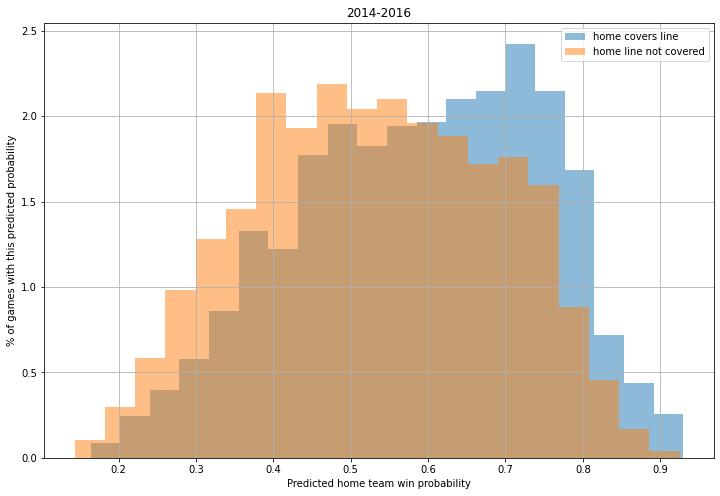

In [283]:
plt.figure(figsize=(12, 8))
train_df[train_df['score_diff'] > -train_df['home_run_line']]['nn_proba'].hist(density=True, alpha=0.5, bins=20, label='home covers line')
train_df[train_df['score_diff'] < -train_df['home_run_line']]['nn_proba'].hist(density=True, alpha=0.5, bins=20, label='home line not covered')
plt.xlabel('Predicted home team win probability')
plt.ylabel('% of games with this predicted probability')
plt.title('2014-2016')
plt.legend();

We'll eyeball a cutoff of 0.6, which will catch a lot of the wins, and not too many of the loses/non-covered wins. This could be better done by optimizing the cutoff and looking at more years, but for right now that's good enough. One other simple idea is to not use a cutoff of 1.5 runs, since we accept that our model isn't perfect. By instead saying "I'll only bet on games where I expect the score differential to be at least (say) 5" will give a larger margin of error. That's not a bad idea to do.

In [284]:
win_cutoff = 0.6

Now for away teams.

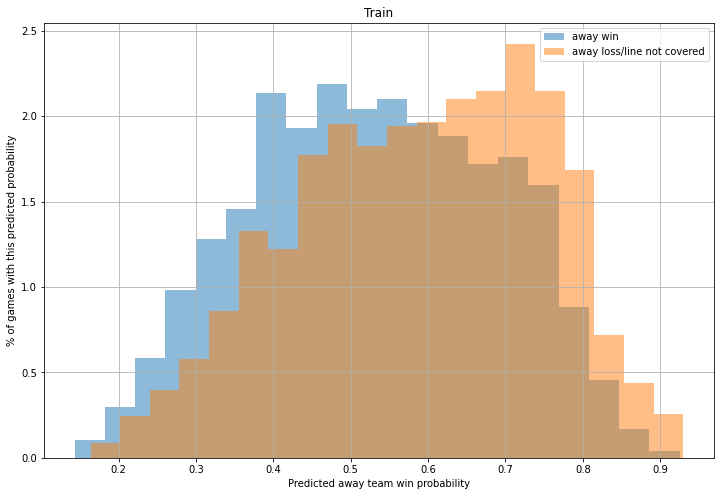

In [287]:
plt.figure(figsize=(12, 8))
train_df[train_df['score_diff'] < train_df['away_run_line']]['nn_proba'].hist(density=True, alpha=0.5, bins=20, label='away win')
train_df[train_df['score_diff'] > train_df['away_run_line']]['nn_proba'].hist(density=True, alpha=0.5, bins=20, label='away loss/line not covered')
plt.xlabel('Predicted away team win probability')
plt.ylabel('% of games with this predicted probability')
plt.title('Train')
plt.legend();

A reasonable balance is struck around 0.5.

In [ ]:
loss_cutoff = 0.5

Nowlet's make predictions. We'll use our cutoffs to predict whether or not the line will be covered. Note that our cutoffs have a "gap" between 0.5 and 0.6. So if the predicted win probability is between 0.5 and 0.6 we won't predict anything. In other words, we won't bet on that game because we're not confident enough in our answers. That strategy could really be refined, and I'm guessing could result in much larger winnings, and much lower draw down (in investing-speak), meaning lower difference between returns on a game-to-game basis.

We'll also record whether the run line was _actually_ covered or not. This uses the ideas outlined above where we discuss what it means to "cover the run line".

Next we incorporate money to find out returns. Per [this description](https://www.playia.com/sports-betting/mlb/run-line/) the money works as follows:
- For favorites (negative run-line) you must wager run line money to win \$100
- For underdogs (positive run-line) you must wager \$100 to win the run line money

So for each game where we make a prediction we'll wager the appropriate amount (\$100 for underdog, run line money for favorite). We'll then track our returns. 

Iterating over rows is bad, but I'm lazy and this is simpler.

Let's move all this into a function though to allow for easier tweaking of the cutoffs to see how that changes things.

In [329]:
def make_wagers(df, win_cutoff, loss_cutoff, verbose=0):
    df['pred_home_cover'] = df['nn_proba'] > win_cutoff
    df['pred_away_cover'] = df['nn_proba'] < loss_cutoff
    
    df['home_cover'] = df['score_diff'] > -df['home_run_line']
    df['away_cover'] = df['score_diff'] < df['away_run_line']
    
    if verbose > 0:
        print(f"Home teams predicted to cover: {100*df['pred_home_cover'].sum() / df.shape[0]:.2f}%")
        print(f"Away teams predicted to cover: {100*df['pred_away_cover'].sum() / df.shape[0]:.2f}%")
    games_wagered = df['pred_home_cover'].sum() + df['pred_away_cover'].sum()
    
    # Use these to track amount wagered and returned
    df['home_wager'] = 0
    df['away_wager'] = 0
    df['home_return'] = 0
    df['away_return'] = 0

    for i in range(df.shape[0]):
        game_row = df.iloc[i]
        # Home team
        # Check if we predicted anything
        if game_row['pred_home_cover']:
            # Favorite (negative) or underdog (positive)?
            if game_row['home_run_line'] < 0:
                df.loc[i, 'home_wager'] = np.abs(game_row['home_run_line_money'])
                # Return of $0 or $100 depending on whether our prediction was correct or not.
                # If you win, don't forget to return the money you bet as well.
                df.loc[i, 'home_return'] = int(game_row['pred_home_cover'] == game_row['home_cover']) * (np.abs(game_row['home_run_line_money']) + 100)
            else:
                df.loc[i, 'home_wager'] = 100
                df.loc[i, 'home_return'] = int(game_row['pred_home_cover'] == game_row['home_cover']) * (100 + game_row['home_run_line_money'])

        # Away team
        # Check if we predicted anything
        if game_row['pred_away_cover']:
            # Favorite (negative) or underdog (positive)?
            if game_row['away_run_line'] < 0:
                df.loc[i, 'away_wager'] = np.abs(game_row['away_run_line_money'])
                # Return of $0 or $100 depending on whether our prediction was correct or not
                df.loc[i, 'away_return'] = int(game_row['pred_away_cover'] == game_row['away_cover']) * (np.abs(game_row['away_run_line_money']) + 100)
            else:
                df.loc[i, 'away_wager'] = 100
                df.loc[i, 'away_return'] = int(game_row['pred_away_cover'] == game_row['away_cover']) * (100 + game_row['away_run_line_money'])
                
    wagered = df['home_wager'].sum() + df['away_wager'].sum()
    returns = df['home_return'].sum() + df['away_return'].sum()
    if wagered > 0:
        returns_pct = (returns - wagered) / wagered
    else:
        returns_pct = None

    if verbose > 1:
        print()
        print(f"Wagered: ${wagered:,}")
        print(f"Returns: ${returns:,}")
        print(f"Win/Losses of ${returns - wagered:,} ({100*returns_pct:.2f}%)")
    return returns_pct, wagered, returns, games_wagered

In [297]:
# Use same cutoffs as above for a sanity check
make_wagers(train_df, win_cutoff=0.6, loss_cutoff=0.5, verbose=2);

Home teams predicted to cover: 42.33%
Away teams predicted to cover: 37.76%

Wagered: $502,918
Returns: $246,919
Win/Losses of $-255,999 (-50.90%)


Let's quickly try a loop.

In [330]:
from itertools import product

loss_cutoff_vals = np.linspace(0, 0.5, 20)
win_cutoff_vals = np.linspace(0.5, 1, 20)
pairs = product(loss_cutoff_vals, win_cutoff_vals)

returns_pct = []
wagers = []
returns = []
games_wagered = []

for loss, win in pairs:
    rp, w, r, gw = make_wagers(train_df, win_cutoff=win, loss_cutoff=loss)
    returns_pct.append(rp)
    wagers.append(w)
    returns.append(r)
    games_wagered.append(gw)

In [331]:
winnings = [r - w for r, w in zip(returns, wagers) if r > w]

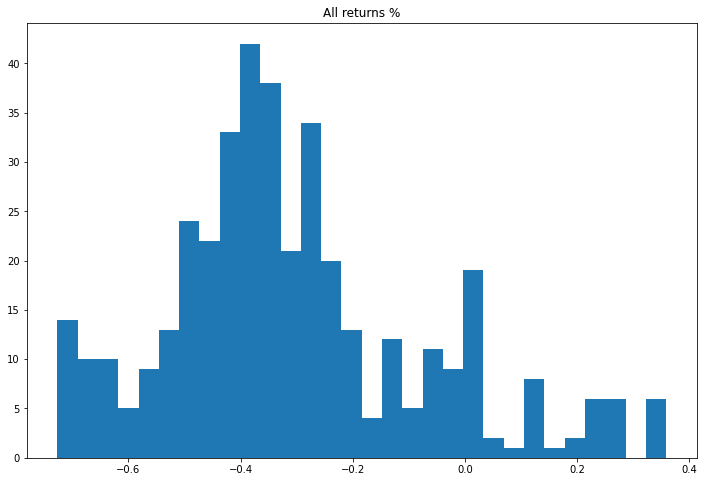

In [347]:
plt.figure(figsize=(12, 8))
plt.hist(returns_pct, bins=30)
plt.title('All returns %');

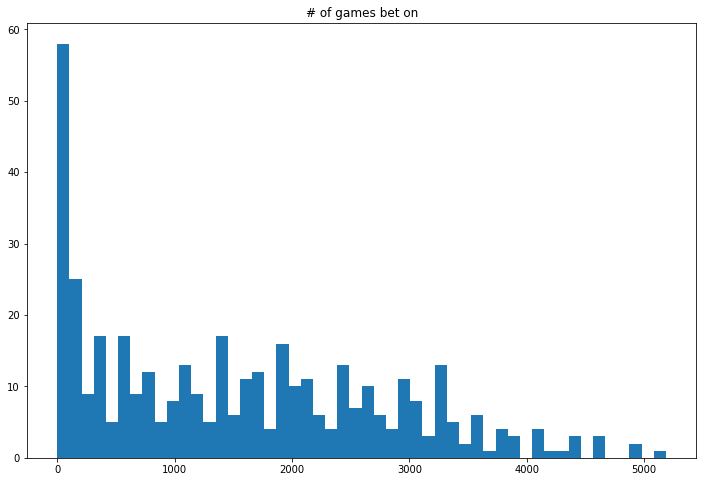

In [338]:
plt.figure(figsize=(12, 8))
plt.hist(games_wagered, bins=50)
plt.title('# of games bet on');

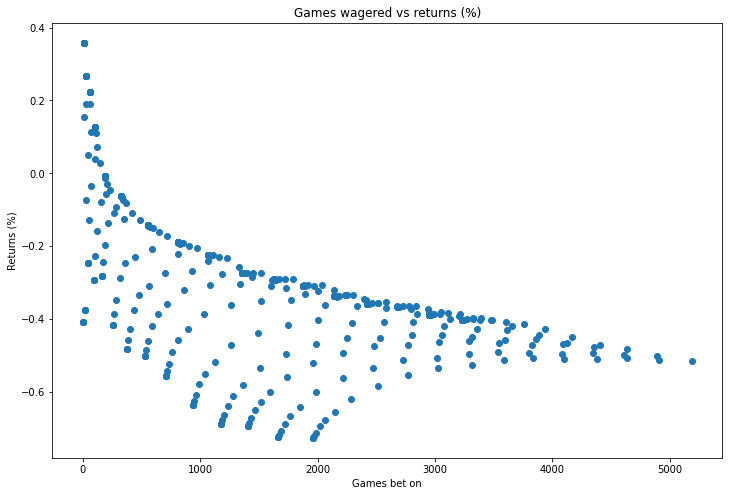

In [341]:
plt.figure(figsize=(12, 8))
plt.scatter(games_wagered, returns_pct)
plt.title('Games wagered vs returns (%)')
plt.xlabel('Games bet on')
plt.ylabel('Returns (%)');

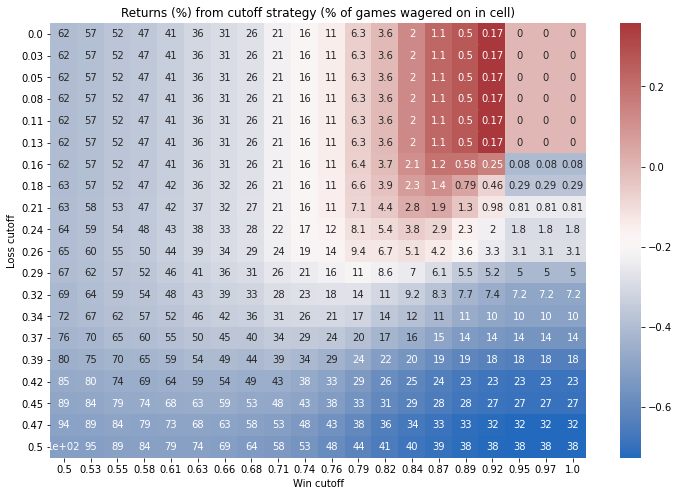

In [354]:
import seaborn as sns

pairs_mat = np.reshape(returns_pct, newshape=(len(loss_cutoff_vals), len(win_cutoff_vals)))
games_wagered_mat = np.reshape(games_wagered, newshape=(len(loss_cutoff_vals), len(win_cutoff_vals)))

plt.figure(figsize=(12, 8))
ax = sns.heatmap(pairs_mat, 
                 cmap='vlag', 
                 annot=np.round(100*games_wagered_mat / train_df.shape[0], 2),
                 xticklabels=np.round(win_cutoff_vals, 2), 
                 yticklabels=np.round(loss_cutoff_vals, 2))
ax.set_xlabel('Win cutoff')
ax.set_ylabel('Loss cutoff')
ax.set_title('Returns (%) from cutoff strategy (% of games wagered on in cell)');

### Weighted betting

Up to this point we have applied a naive strategy involving picking a cutoff and choosing to bet or not bet solely based on that, with the same amount bet regardless of the game. However, the heatmap above suggests that winning (or losing) occurs on a continuum, and fixing a cutoff will always involve lots of losses near the cutoff. So a better strategy may be to weight our money wagered by the probability of winning.

Let $p_i$ denote the probability of a home-team win in game $g_i$, and $m_i$ denote the money wagered in game $g_i$. Since a probability close to zero means betting on an away team win, we'll scale the probabilities between -1 and 1. Then, we'll wager proportional to the square of the probability. That way, games with a predicted probability near 0 (toss-ups) will have little-to-nothing wagered, and games with a high probability of win (near -1 and 1) will have higher wagers. Based on the heatmap above, it looks like it may actually be advantageous to make it proportional to a larger power or even an exponential function, since most of the winnings occur just in the small area near the edges. But for now we'll stick with this simple approach.

Finally, in the betting data above the amount we bet varied depending on the cutoff. Since we wagered the same amount on every game, the amount we bet was proportional to the number of games exceeding our cutoff. This meant we could compare returns as a percentage, but not as a dollar amount. So this time we'll fix an investment (say, \$100) and apportion it across all games.

We'll do this by calculating the money invested over all games, and then multipy by 100 / total money wagered to ensure betting only \$100.

In [544]:
def calc_home_wager(x):
    return int(x['nn_proba'] > 0.5)*(2*x['nn_proba'] - 1)**3

def calc_away_wager(x):
    return int(x['nn_proba'] < 0.5)*(2*x['nn_proba'] - 1)**3

In [545]:
def calc_home_returns(x):
    # If they're the favorite (negative run line), returns are bet * (run line money / 100)
    # If they're the underdog (positive run line), returns are bet * (100 / run line money)
    if x['home_run_line'] < 0:
        return x['home_wager'] * (np.abs(x['home_run_line_money']) / 100)
    else:
        return x['home_wager'] * (100 / np.abs(x['home_run_line_money']))

def calc_away_returns(x):
    if x['away_run_line'] < 0:
        return x['away_wager'] * (np.abs(x['away_run_line_money']) / 100)
    else:
        return x['away_wager'] * (100 / np.abs(x['away_run_line_money']))

In [546]:
# Calculate wagers
train_df['home_wager'] = train_df.apply(calc_home_wager, axis=1)
train_df['away_wager'] = train_df.apply(calc_away_wager, axis=1)

# Correct the wagers to sum to $1
total_wagered = train_df['home_wager'].sum() + train_df['away_wager'].sum()
train_df['home_wager'] = train_df['home_wager'] / total_wagered
train_df['away_wager'] = train_df['away_wager'] / total_wagered

In [547]:
# Calculate returns
train_df['home_returns'] = train_df.apply(calc_home_returns, axis=1)
train_df['away_returns'] = train_df.apply(calc_away_returns, axis=1)

In [548]:
per_game_returns = train_df['home_returns'] + train_df['away_returns'] - (train_df['home_wager'] + train_df['away_wager'])                  

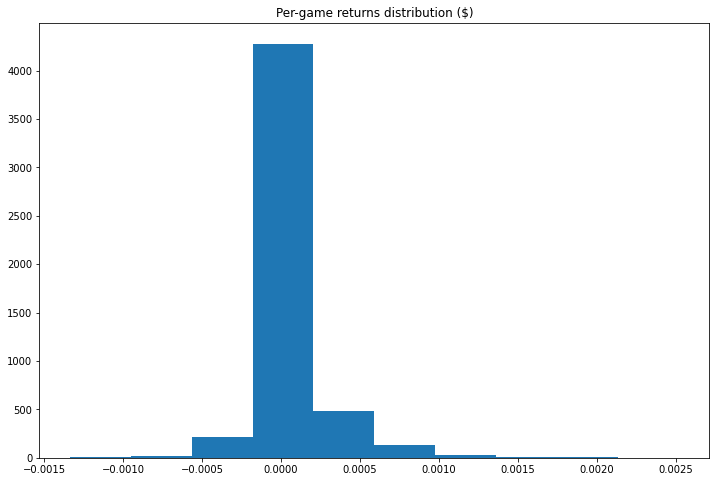

In [549]:
plt.figure(figsize=(12, 8))
plt.hist(per_game_returns)
plt.title('Per-game returns distribution ($)');

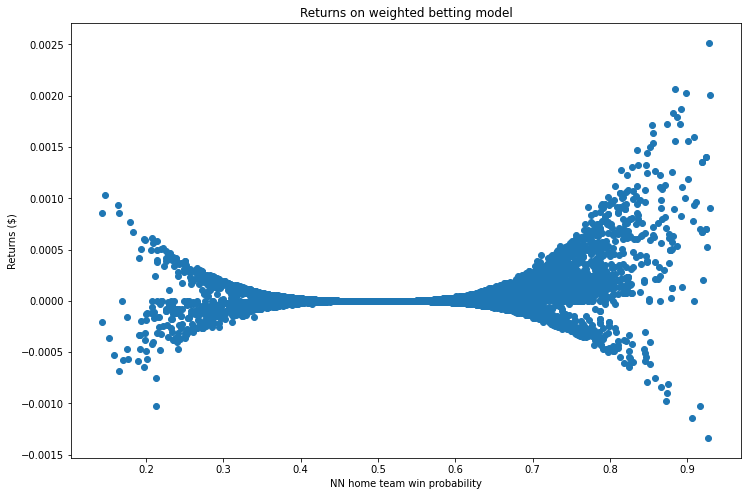

In [552]:
plt.figure(figsize=(12, 8))
plt.scatter(train_df['nn_proba'], per_game_returns)
plt.xlabel('NN home team win probability')
plt.ylabel('Returns ($)')
plt.title('Returns on weighted betting model');

In [551]:
total_pct_returns = per_game_returns.sum() / (train_df['home_wager'] + train_df['away_wager']).sum()
print(f'Total returns of {100*total_pct_returns:.2f}%')

Total returns of 32.18%
